# Celebrity Face Generation with GANs

In [1]:
# imports
import cv2
import numpy as np
import pandas as pd
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
import glob
import math
import torchvision.models as models
import PIL.Image
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from torchvision.datasets import ImageFolder

%matplotlib inline

c:\Users\Admin\anaconda3\envs\gan-aiap\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Config 

Modify the config parameters if you need to experiment.

Reference for GAN losses: 

- LSGAN: https://sh-tsang.medium.com/review-lsgan-least-squares-generative-adversarial-networks-gan-bec12167e915

- Minimax loss: https://developers.google.com/machine-learning/gan/loss

- WGAN loss: https://jonathan-hui.medium.com/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490

In [2]:
#### Main config parameters
RANDOM_SEED = 42
C = 0.05 # Clip value for WGAN to fulfil lipschitz condition
N_SAMPLES = 10000

# Image size to rescale for neural nets
IMAGE_SIZE = 64
BATCH_SIZE = 128

# Hyperparameters for model training
LR = 0.00025
EPOCHS = 60

# GAN mode to use, either lsgan, gan or wgan
MODE = 'gan'

# Config for transfer learning
TRANSFER_LEARNING = True

# CONTROLS Number of times critic is updated for each update to generator model. Applicable for GAN
N_CRITIC = 5 

# Set Latent Space Dimension for generator to use for image generation
LATENT_SIZE = 128


# Data directory to be used for sample data subsets for training.
WORKING_DATA_DIR = os.path.join(
    os.getcwd(), 
    'data',
    'sample',
    'train'
)

# Directory to store generated image samples
SAMPLE_DIR_GENERATED_IMAGE = os.path.join(os.getcwd(), 
                                          'generated',
                                          MODE,
                                          'xfer_{}'.format(TRANSFER_LEARNING),
                                          str(N_SAMPLES))

# Directory to store model checkpoints information
CHECKPOINT_DIR = os.path.join(os.getcwd(), 
                              'checkpoint',
                              MODE,
                              'xfer_{}'.format(TRANSFER_LEARNING),
                              str(N_SAMPLES))

# Directory to store csv files containing model loss and score metrics 
MODEL_DIR = os.path.join(os.getcwd(), 
                        'model',
                         MODE,
                         'xfer_{}'.format(TRANSFER_LEARNING),
                         str(N_SAMPLES))


METRICS_FILE = 'metrics-{}-samples-{}-xfer-learn-{}.csv'\
    .format(MODE, N_SAMPLES, TRANSFER_LEARNING)

# Torch config for reproducibility
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#### Check data directory

Calculate number of samples

In [3]:
DATA_DIR = os.path.join(
    os.getcwd(), 
    'celeba',
    'img_align_celeba',
)

image_list = [i for i in os.listdir(DATA_DIR)]

numSamples = len(os.listdir(DATA_DIR))
numSamples

202599

#### Take only N_SAMPLES (as defined above) as working data and put it in separate directory. Create other directories if needed

In [4]:
# Clean old contents in training dataset
if os.path.exists(WORKING_DATA_DIR):
    shutil.rmtree(WORKING_DATA_DIR)

# Create directories 
os.makedirs(WORKING_DATA_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# Take the first N_SAMPLES
image_samples_list = image_list[:N_SAMPLES]

try:
    for img_path in image_samples_list:
        source_path = os.path.join(DATA_DIR, img_path)
        dest_path = os.path.join(WORKING_DATA_DIR, img_path)
        shutil.copy(source_path, dest_path)
except:
    raise IOError

#### Check resolutions of images in sample working directory

Check for consistencies in the image resolutions

In [5]:
sample_image_path = [os.path.join(WORKING_DATA_DIR, img) \
                     for img in image_samples_list]

image_res = {cv2.imread(img).shape for img in sample_image_path}
image_res

{(218, 178, 3)}

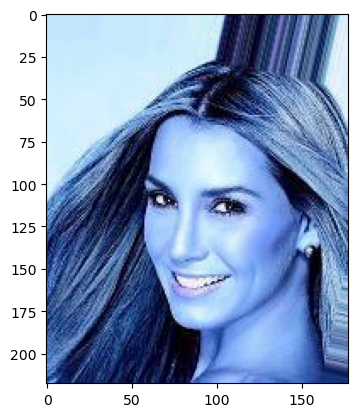

In [6]:
# Check image is it rgb or bgr

image = cv2.imread(sample_image_path[0])

plt.imshow(image)

#### Calculate mean and standard deivation of rgb channels of the dataset

In [7]:
def cal_mean_std(images_dir):
    """
    Calculates mean and standard deviation of images channel in a given directory using cv2 meanStdDev library. The mean and standard deviation are in BGR channel order.

    Args:
        images_dir (string): Directory storing images to be referred to for channel mean/std calculation.

    Returns:
        mean_arr (numpy array): 2D numpy array representing the mean values in BGR channel
        std_dev_arr (numpy array): 2D numpy array representing the standard deviation of values in BGR channel
    Raises:
        IOError: File doesnt exist.
    """
    img_filenames = os.listdir(images_dir)
    print("Reading images from: {}".format(images_dir))
    mean_list, std_list = [], []

    for img_filename in img_filenames:
        try:
            img = cv2.imread(os.path.join(images_dir, img_filename))
            img = img / 255.0
            m, s = cv2.meanStdDev(img)

            mean_list.append(m.reshape((3,)))
            std_list.append(s.reshape((3,)))
        except:
            raise IOError
        
    mean_array = np.array(mean_list)
    std_array = np.array(std_list)
    mean_arr = mean_array.mean(axis=0, keepdims=True)
    std_dev_arr = std_array.mean(axis=0, keepdims=True)

    return mean_arr, std_dev_arr 

In [8]:
mean, std = cal_mean_std(WORKING_DATA_DIR)
print(mean, std)

# RGB mean and std for normalisation from dataset
stats = tuple(mean.squeeze(0)), tuple(std.squeeze(0))
stats

Reading images from: c:\Users\Admin\Desktop\GAN_sharing_AIAP\data\sample\train
[[0.38357434 0.42607775 0.50656073]] [[0.24154939 0.24559601 0.26624827]]


((0.38357433582752637, 0.4260777473517026, 0.5065607319034985),
 (0.24154939462015396, 0.24559601472868445, 0.26624826983051775))

Let's load this dataset using the ImageFolder class from torchvision. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range (-1, 1), which is more convenient for training the discriminator. We will also create a data loader to load the data in batches.

#### Define torch imagefolder (for transforms) and dataloader (prepare for data batches for model training)

In [9]:
image_transformer = T.Compose([
    T.Resize(IMAGE_SIZE),
    T.CenterCrop(IMAGE_SIZE), # Central square crop
    T.ToTensor(),
    T.Normalize(*stats)   # normalize => -1 to 1                               
])
 
# Pytorch has torchvision.datasets.CelebA to download. I did it via manually, hence ImageFolder is used instead. (Allows cuts)
train_ds = ImageFolder(
    root=os.path.dirname(WORKING_DATA_DIR), 
    transform=image_transformer
)

train_dl = DataLoader(
    train_ds, 
    BATCH_SIZE,
    shuffle=True,
    num_workers=3,# use some cores
    pin_memory=True # Speed up host to device transfer for training on gpu
) 


Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.



In [10]:
def denorm(img_tensors, stats):
    """Function which denormalises image tensor with specified mean and standard deviation.

    Args:
        img_tensors (torch tensors): 
            Pytorch tensors
        stats (numpy array):
            Array containing mean and standard deviation of bgr channel values for training dataset.

    Returns:
        img_tensors that are denormalised
    Raises:
        None
    """
    mean = torch.tensor(stats[0])
    std = torch.tensor(stats[1])

    unnormalize = T.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
    img_unn = unnormalize(img_tensors)

    return img_unn

# Helper function to show images

def show_images(images, stats, nmax=64):
    """Function which uses imshow to display image from pytorch tensors in a grid.

    Args:
        img_tensors (torch tensors): 
            Pytorch tensors.
        stats (numpy array): 
            Array containing mean and standard deviation of bgr channel values for training dataset.
        nmax (int): 
            Number of images to show, ideally should be less than the batch size set for dataloader. Defaults to 64.

    Returns:
        img_tensors that are denormalised.

    Raises:
        None
    """
    _, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])

    #In Pytorch -> C x H x W whereas Matplotlib reques H x W x C. So, permute(1, 2, 0) do this.
    ax.imshow(make_grid(denorm(images.detach()[:nmax], stats), nrow=8).permute(1, 2, 0))
    return None
  
def show_batch(dl, stats, nmax=64):
    """Function that calls show_images to display images using tensors from Pytorch DataLoader.

    Args:
        dl (torch dataloader): 
            Pytorch DataLoader for a particular directory.
        stats (numpy array): 
            Array containing mean and standard deviation of bgr channel values for training dataset.
        nmax (int): 
            Number of images to show, ideally should be less than the batch size set for dataloader. Defaults to 64.

    Returns:
        None

    Raises:
        None
    """
    for images, _ in dl:
        show_images(images, stats, nmax)
        break  
    return None

#### Show sample data batches (32 images) from dataloader 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


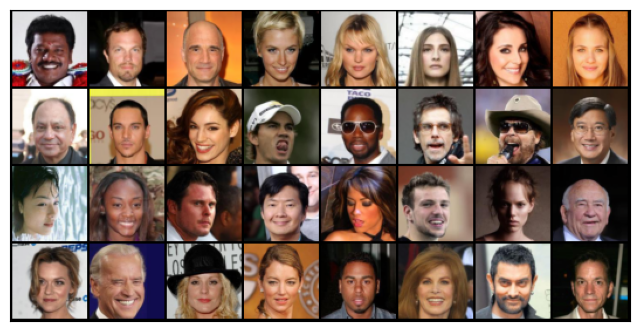

In [11]:
show_batch(train_dl, stats, nmax=32)

Helper functions to load data onto cpu/gpu device based on detected hardware

In [12]:
def get_default_device():
    """Retrieves PC's cuda availability and returns the device to use.

    Args:
      None

    Returns:
        Specific torch device to use (e.g torch.device(device name))

    Raises:
        None
    """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move all data types to provided device index.
    
    Args:
        data (torch tensor):
            Data in torch tensor.
        device (torch device):
            Device info/index for data loading.

    Returns:
        Data loading to device input stated.

    Raises:
        None
    
    """
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device that is detected in batches.
    
    """
    def __init__(self, dl, device):
        """Constructor to instantiate dataloader and device attributes for the class.
    
        Args:
            dl (torch dataloader):
                Pytorch dataloader
            device (torch device):
                Device info/index for data loading

        Returns:
            None

        Raises:
            None
        
        """
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device.
        
        Args:
            Mone

        Returns:
            None

        Raises:
            None
        
        """
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Return size of data batches in dataloader
        Args:
            Mone

        Returns:
            Size of data batchers in dataloader

        Raises:
            None
        
        """
        return len(self.dl)

In [13]:
# Check device
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)

# Build GAN

## Discriminator Network/ Critic Network for case of WGAN

Define discriminator/critic network arcchitecture with deep convolutional Layers as per DCGAN

**Remarks: Critic is the official term for discriminator in the case of WGAN, with the last layer changed from sigmoid to a linear layer. The same architecture is used for LSGAN due to loss construct. 

The further difference between LSGAN and WSGAN is that critic is updated more frequently than typical discriminator by design.** 


#### Vanilla Discriminator/Critic Architecture

In [15]:
discriminator = nn.Sequential(
    # in: 3x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    # Flatten to provide output whether isit 1 or 0
    nn.Flatten(),
    # out: dimension 1 (logit)

    # To decide if a generated image is fake/real based on real image
    nn.Sigmoid()
    # out: dimension 1 (logit)
)

critic = nn.Sequential(
    # in: 3x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    # Flatten to provide output whether isit 1 or 0
    nn.Flatten(),

    # To output a value (like regression)
    nn.Linear(1,1)
)

#### Transfer learning for Discriminator/Critic Architecture

In [20]:
# Load vgg16 model (16 convolutional neural network)
vgg16 = models.vgg16_bn()

# Freeze weights in pretrained model
for param in vgg16.features.parameters():
    param.require_grad = False

# Define pretrained layers from vgg16
pretrained_layers = list(vgg16.features)[:22]


# Define customised layers for discriminator to be attached on top of vgg16, with general construct of last layers similar to vanilla discriminator
customised_layers_disc = [
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    # Flatten to provide output whether isit 1 or 0
    nn.Flatten(),

    # To decide if a generated image is fake/real based on real image
    nn.Sigmoid()
]

# Define customised layers for critic to be attached on top of vgg16, retaining last layer to be linear activation instead of sigmoid
customised_layers_critic = [
    
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    # Flatten to provide output whether isit 1 or 0
    nn.Flatten(),

    # To output a value (like regression)
    nn.Linear(1,1)
]

# Combine layers for case of GAN/LGAN
discriminator_pre_trained = nn.Sequential(
    *(pretrained_layers + customised_layers_disc)
)

# Combine layers for case of WGAN
critic_pre_trained = nn.Sequential(
    *(pretrained_layers + customised_layers_critic)
)

Load pre-trained or vanilla discriminator/critic into discriminator variable based on *MODE* and *TRANSFER_LEARNING* config value.

Remarks: Critic is the official term for discriminator WGAN, with the last layer changed from sigmoid to a linear layer. Same architecture is used for LSGAN due to loss construct.

In [21]:
print(TRANSFER_LEARNING, MODE)

True gan


In [22]:
if TRANSFER_LEARNING == False:
    if MODE == 'gan':
        discriminator = to_device(discriminator, device)
    else:   
        discriminator = to_device(critic, device)
else:
    if MODE == 'gan':
        discriminator = to_device(discriminator_pre_trained, device)
    else:   
        discriminator = to_device(critic_pre_trained, device)

#### Lets print output shape after each layer of discrminator/critic.

In [23]:
# create a tensor Batch_Size,C,H,W
X = torch.rand(size=(1, 3, 64, 64), dtype=torch.float32, device=device) 
for layer in discriminator:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 64, 64, 64])
BatchNorm2d output shape: 	 torch.Size([1, 64, 64, 64])
ReLU output shape: 	 torch.Size([1, 64, 64, 64])
Conv2d output shape: 	 torch.Size([1, 64, 64, 64])
BatchNorm2d output shape: 	 torch.Size([1, 64, 64, 64])
ReLU output shape: 	 torch.Size([1, 64, 64, 64])
MaxPool2d output shape: 	 torch.Size([1, 64, 32, 32])
Conv2d output shape: 	 torch.Size([1, 128, 32, 32])
BatchNorm2d output shape: 	 torch.Size([1, 128, 32, 32])
ReLU output shape: 	 torch.Size([1, 128, 32, 32])
Conv2d output shape: 	 torch.Size([1, 128, 32, 32])
BatchNorm2d output shape: 	 torch.Size([1, 128, 32, 32])
ReLU output shape: 	 torch.Size([1, 128, 32, 32])
MaxPool2d output shape: 	 torch.Size([1, 128, 16, 16])
Conv2d output shape: 	 torch.Size([1, 256, 16, 16])
BatchNorm2d output shape: 	 torch.Size([1, 256, 16, 16])
ReLU output shape: 	 torch.Size([1, 256, 16, 16])
Conv2d output shape: 	 torch.Size([1, 256, 16, 16])
BatchNorm2d output shape: 	 torch.Size([1, 256, 16

# Generator Network

Transposed convolutional layers are the primary building blocks for the generator (Kind of reverse process of convolution to restore original inputs to conv).
Through learning we can find the kernel that restores it.

(Ref: https://towardsdatascience.com/understand-transposed-convolutions-and-build-your-own-transposed-convolution-layer-from-scratch-4f5d97b2967)

Based on the journal article titled "The Effect of Latent Space Dimension on the
Quality of Synthesized Human Face Images" by Marin, Gotovac, Russo and Stulic, there are various latent dimensions used such as 100, 512, 64 or 128.

**Additional Notes**:
- Latent space has no meaning by itself but rather a hypersphere with each variable drawn from a Gaussian distribution of N(0,1)- an arbitrary distribution. It has structure when interpreted by generator model.

- Latent(hidden) basically can be attributed to the following ideas:

    - We map higher dimensional data to a lower dimensional data with no prior convictions of how the mapping will be done. The NN trains itself for the best configuration.
    - We cannot manipulate this lower dimensional data. Thus it is "hidden from us.
    - As we do not know what each dimension means, it is "hidden" from us.

It is related to Hidden Markov model concept. Think of seeing a shadow of humans behind a wall. I can only see


#### Define structure of generator for generating fake images
Ideally the generator layers are "reverse" of discriminator so as to generate images. This is done by keeping the kernel size, stride and padding the same as used in discriminator architecture, while reversing the layers.

In [24]:
generator = nn.Sequential(
    # input: latent vector of latent_size x 1 x 1

    nn.ConvTranspose2d(LATENT_SIZE, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()  # output is between -1 to 1
    # out: 3 x 64 x 64
)

#### Lets print output shape after each layer of generator.

In [25]:
X = torch.randn(size=(1, 128, 1, 1))
for layer in generator:
  X = layer(X)
  print(layer.__class__.__name__,'output shape: \t',X.shape)

ConvTranspose2d output shape: 	 torch.Size([1, 512, 4, 4])
BatchNorm2d output shape: 	 torch.Size([1, 512, 4, 4])
ReLU output shape: 	 torch.Size([1, 512, 4, 4])
ConvTranspose2d output shape: 	 torch.Size([1, 256, 8, 8])
BatchNorm2d output shape: 	 torch.Size([1, 256, 8, 8])
ReLU output shape: 	 torch.Size([1, 256, 8, 8])
ConvTranspose2d output shape: 	 torch.Size([1, 128, 16, 16])
BatchNorm2d output shape: 	 torch.Size([1, 128, 16, 16])
ReLU output shape: 	 torch.Size([1, 128, 16, 16])
ConvTranspose2d output shape: 	 torch.Size([1, 64, 32, 32])
BatchNorm2d output shape: 	 torch.Size([1, 64, 32, 32])
ReLU output shape: 	 torch.Size([1, 64, 32, 32])
ConvTranspose2d output shape: 	 torch.Size([1, 3, 64, 64])
Tanh output shape: 	 torch.Size([1, 3, 64, 64])


#### Visualise generated images prior to training using a batch of latent sized vector sampled from random normal distribution 

torch.Size([128, 3, 64, 64])


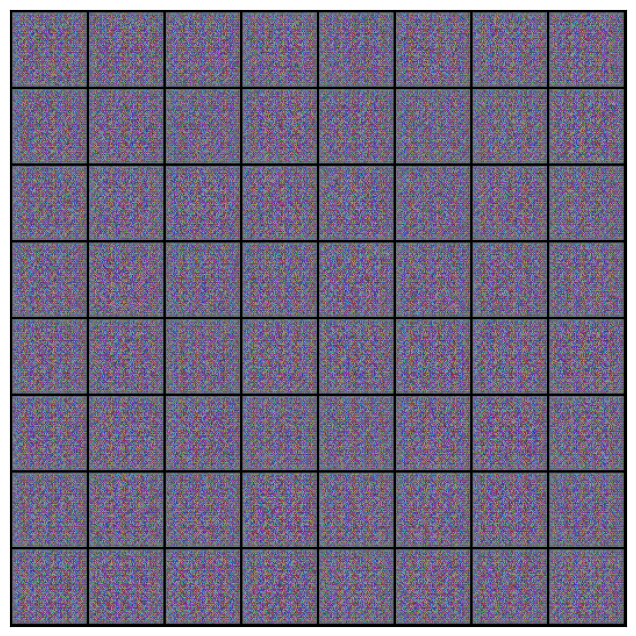

In [26]:
# Create a latent tensors of batch_size using  (* latent_size * 1 * 1) vector (N,C,H,W) with values normally distributed

xb = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1) # random latent tensors
fake_images = generator(xb)

print(fake_images.shape)
show_images(fake_images, stats)


Move generator to device for subsequent training

In [27]:
generator = to_device(generator, device)

## Training Discriminator

Discriminator should accept 2 inputs: 1 actual image and 1 generated image

In [28]:
def train_discriminator(real_images,
                        opt_d,
                        discriminator_obj,
                        generator_obj,
                        batch_size=64,
                        latent_size=128,
                        mode='wgan'):
    """Function that constructs the process of discriminator training and calculates the loss of discriminator.
    
    Args:
        real_images (torch tensor): 
            Data in torch tensor
        discriminator_obj (Torch Sequential object):
          A defined sequence of neural network layers for generator.
        generator_obj (Torch Sequential object):
          A defined sequence of neural network layers for generator.
        batch_size (int): 
            Batch size of data for each pass. Defaults to 64.
        latent_size (int):
            Vector size of latent variable. Defaults to 128.
        opt_d (optimizer):
            Torch optimizer function.
        mode (string): 
            GAN mode that affects the loss function used.

    Returns:
        loss.item (torch): 
            Loss information by discriminator.
        real_score (float):
            Measures how well it is able to discriminate real image.
        fake_score (float):
            Measures how well it is able to discriminate generated image.
    Raises:
        NotImplementedError: For other mode types not belonging to gan/lsgan/wgan

    
    """
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Real image case: Pass real images through  discriminator and assign value 1 to indicate real
    real_preds = discriminator_obj(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    
    # Fake image case: Generate fake image using latent vector for a batch of data
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator_obj(latent)

    # Pass Fake images through discriminator and declare them as 0 since we want discriminator to be 0
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator_obj(fake_images)

    # Calculate losses based on gan variant used, as dictated by mode
    if mode=='gan':
        real_loss = F.binary_cross_entropy(real_preds, real_targets)
        fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
        loss = real_loss + fake_loss


    elif mode=='lsgan':
        # L2 loss function for discriminator involving (D(x) - b) and D(G(z))-a) where a is label for fake data and b is label for real data.

        mse_loss = torch.nn.MSELoss()
        real_loss = mse_loss(real_preds, real_targets)
        fake_loss = mse_loss(fake_preds, fake_targets)
        loss = 0.5 * (real_loss + fake_loss)

    elif mode== 'wgan':
        # The discriminator doesnt really classify, but output a number (bigger for real than for fake) aka Critic loss. D(x) - D(G(z)). Since Discriminator needs to maximize this, it is equivalent to minimizing the negative of this.

        loss = -(real_preds.mean() - fake_preds.mean())
        
        # Clip weights to be in a constrained value. This is to enforce the Lipschitz constraint on the critic’s model loss function
        c = C
        
        # Clamp values to constrained range
        for p in discriminator.parameters():
            p.data.clamp_(-c, c)
    else:
        raise NotImplementedError
    
    # Combine loss and backward propagate
    loss.backward()
    opt_d.step()
    
    real_score = torch.mean(real_preds).item()

    fake_score = torch.mean(fake_preds).item()
    return loss.item(), real_score, fake_score



Here are the steps involved in training the discriminator.

* We expect the discriminator to output 1 if the image was picked from the real Anime Faces dataset, and 0 if it was generated using the generator network.

* We first pass a batch of real images, and compute the loss, setting the target labels to 1.

* Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0.

* Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.



It's important to note that we don't change the weights of the generator model while training the discriminator (opt_d only affects the discriminator.parameters())

## Generator Training

* We generate a batch of images using the generator, pass the into the discriminator.

* We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

* We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

In [29]:
def train_generator(opt_g, 
                    discriminator_obj,
                    generator_obj,
                    batch_size=64,
                    latent_size=128,
                    mode = 'wgan'):
    """Function that implements the generator model process in generating image for discriminator to be fooled and calculates the losses obtained using discriminator response against supposedly real labels (response =1).

    Args:
        opt_g (optimizer):
            Torch optimizer for generator
        discriminator_obj (Torch Sequential object):
          A defined sequence of neural network layers for generator
        generator_obj (Torch Sequential object):
          A defined sequence of neural network layers for generator
        batch_size (int):
            Amount of batch data to be generated using stated latent_size vector. Defaults to 64
        latent_size (int):
            Vector size of latent variable. Default to 128.
        mode (string):
            GAN mode determining the loss function to use

    Returns:
        loss.item() (tensor contents): Contents of generator loss values

    Raises:
        NotImplementedError: When modes are not gan or lsgan or wgan
    
    """
    # Clear generator gradients before training
    opt_g.zero_grad()

    # Generate fake images of batch_size using latent_vector
    latent = torch.randn(batch_size, latent_size, 1,1, device=device)
    fake_images = generator_obj(latent)

    # Send image for discriminator response
    preds = discriminator_obj(fake_images)
    targets = torch.ones(batch_size, 1, device=device)

    if mode =='gan':
        loss = F.binary_cross_entropy(preds, targets)

    elif mode =='lsgan':
        # Similar to a-b decoding scheme in discriminator we now set label as 1 as we want generator to generate images that are as real as possible, hence -1
        mse_loss = torch.nn.MSELoss()
        loss = mse_loss(preds, targets)

    elif mode == 'wgan':
        # Evaluate mean of predictions for generated images
        loss = -preds.mean()
        
    else:
        raise NotImplementedError
    # Calculate loss based on response value and supposed 'real' target


    # Update generator 
    loss.backward()
    opt_g.step()

    return loss.item()

Create a directory to store model checkpoints and save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [30]:
os.makedirs(SAMPLE_DIR_GENERATED_IMAGE , exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [31]:
def save_samples(index, sample_dir, latent_tensors, generator_obj, stats, show=True):
    """Function that saves generated image using provided latent tensors, while providing visualisation if 'show' argument is True.

    Args:
        index (int):
            Index for use in file name of image used for saving.
        sample_dir (string):
            Directory to store generated images.
        latent_tensors (torch tensor):
            Torch tensor representation of tensor to be used for generating fake images.
        generator_obj (Torch Sequential object):
            A defined sequence of neural network layers of generator object.
        stats (numpy array): 
            Array containing mean and standard deviation of bgr channel values for training dataset. 
        show (bool):
            State to determine whether to plot generate images.

    Returns:
        None

    Raises:
        None
    
    """
    # Create fake images
    fake_images = generator_obj(latent_tensors)

    # Filenamem for generated image
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)

    save_img_path = os.path.join(sample_dir, fake_fname)
    save_image(denorm(fake_images, stats), save_img_path, nrow=8)
    print("Saving generated image to", save_img_path)

    # Plot out generated image using subplot
    if show:
        _, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
    
    return None

## Training Loop

In [32]:
# Helper functions
def checkpoint(model, model_dir, filename):
    """Function that saves existing model state dictionary into specified path.

    Args:
        model (Torch model):
            Pytorch model.
        model_dir (string):
            Directory to store model artifacts.
        filename (string):
            Filename of model artifacts.

    Returns:
        None

    Raises:
        None
    
    """
    torch.save(model.state_dict(), os.path.join(model_dir, filename))


def save_metrics(model_dir, filename, index_label, **kwargs):
    """Function that saves model training metrics to providied path.

    Args:
        model_dir (string):
            Directory to store model artifacts.
        filename (string):
            Filename of model artifacts.

    Returns:
        None
        
    Raises:
        None
    
    """
    df = pd.DataFrame(kwargs)
    df.to_csv(os.path.join(model_dir,filename), index_label = index_label)

In [33]:
def fit(epochs, lr, batch_size, latent, model_dir, checkpoint_dir, sample_dir, discriminator_obj, generator_obj, stats, metrics_file, mode='wgan'):
    """This functions implements the training process for generator and discriminator, with discriminator learning to identify real images before discriminating fake images.
    
    Args:
      epochs (int): 
          Number of epochs for model training.
      lr (float):
          Learning rate for gradient descent.
      batch_size (int):
          Size of batches to be used for fitting.
      latent (torch tensor):
          Latent tensor for generating image.
      model_dir (string): 
          Directory which model metrics would be stored.
      checkpoint_dir (string): 
          Directory which model checkpoints would be stored.
      sample_dir (string): 
          Directory which generated image would be saved.
      discriminator_obj (Torch Sequential object):
          A defined sequence of neural network layers for generator.
      generator_obj (Torch Sequential object):
          A defined sequence of neural network layers for generator.
      stats (numpy array): 
          Array containing mean and standard deviation of bgr channel values for training dataset.
      metrics_file (string):
          Input filename to store model metrics.
      mode (string):
          GAN modes to determine the loss function for use.

    Returns:
        losses_g (list): Measures losses of generator.
        losses_d (list): Measures losses of discriminator.
        real_scores (list): Measures the discriminator performance on identifying real images.
        fake_scores (list): Measures how well it is able to discriminate generated image as fakes.
    Raises:
        None
    """
    # Empty any content in cuda 
    torch.cuda.empty_cache()

    # Losses & scores for generator and discriminator
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers for discriminator
    opt_d = torch.optim.Adam(discriminator_obj.parameters(), 
                             lr=lr,
                             betas=(0.5, 0.999))
    
    opt_g = torch.optim.Adam(generator_obj.parameters(),
                             lr=lr,
                             betas=(0.5, 0.999))

   
    # Loop through epoch and include losses and scores for both generator and discriminator. For LSGAN and DCGAN, updates are equal.
    # Clearing of gradients are done in train_discriminator and train_generator respectively.
    for epoch in range(epochs):
        for real_images, _ in train_dl:
            
            # Train discriminator with specified optimizer. Becomes critic model for WGAN case which is updated more frequently than generator case 
            if mode != 'wgan':
                loss_d, real_score, fake_score = train_discriminator(\
                    real_images,
                    opt_d,
                    discriminator_obj, 
                    generator_obj,
                    batch_size,
                    latent.shape[1], 
                    mode
                )

            else:
                # Update critic(discriminator) for n_critic by WGAN design
                for _ in range(N_CRITIC):
                    loss_d, real_score, fake_score = train_discriminator(\
                        real_images,
                        opt_d,
                        discriminator_obj,
                        generator_obj, 
                        batch_size,
                        latent.shape[1], 
                        mode
                )

            # Train generator with specified optimizer
            loss_g = train_generator(
                opt_g,
                discriminator_obj,
                generator_obj, 
                batch_size,
                latent.shape[1],
                mode=mode
            )

            # Record losses & scores by epoch (after processing last batch of data in dataloader)
            losses_g.append(loss_g)
            losses_d.append(loss_d)

            # discriminator avg probability on real data (higher is better score for discriminator)
            real_scores.append(real_score)

            # discriminator avg probability on fake data (higher is better score for generator)
            fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g for {}: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, mode, loss_g, loss_d, real_score, fake_score))

        # Save discriminator and generator model weights and generated images after each epoch
        checkpoint(generator, 
                   checkpoint_dir,
                   'Generator_{}_{}.pth'.format(mode,epoch+1))
        
        checkpoint(discriminator,
                   checkpoint_dir,
                   'Discriminator_{}_{}.pth'.format(mode,epoch+1))
        
        # Save generated images based on GAN mode information
        save_samples(epoch+1, sample_dir, latent, generator_obj, stats, show=False)

    save_metrics(model_dir, metrics_file , 'Cycle', G_loss = losses_g, D_loss = losses_d, Real_score = real_scores, Fake_score = fake_scores)
    return losses_g, losses_d, real_scores, fake_scores

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated image to c:\Users\Admin\Desktop\GAN_sharing_AIAP\generated\gan\xfer_True\10000\generated-images-0000.png


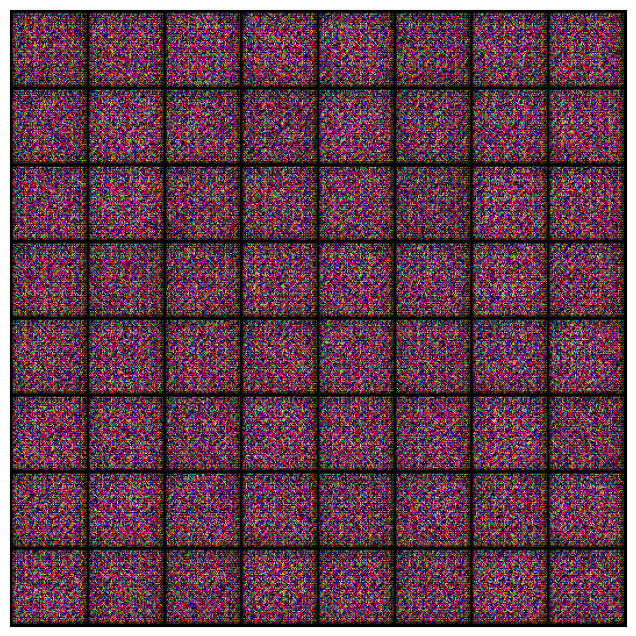

In [34]:
# Matrix of 64 datapoints represented by LATENT_SIZE,1,1 matrix
fix_latent = torch.randn(64, LATENT_SIZE, 1, 1, device=device)
save_samples(0, SAMPLE_DIR_GENERATED_IMAGE, fix_latent, 
             generator_obj=generator, stats=stats)

We are now ready to train the model. Try different learning rates to see if you can maintain the fine balance between the training the generator and the discriminator.



In [35]:

history = fit(EPOCHS,
              LR,
              BATCH_SIZE,
              fix_latent,
              model_dir=MODEL_DIR,
              checkpoint_dir=CHECKPOINT_DIR,
              sample_dir=SAMPLE_DIR_GENERATED_IMAGE,
              discriminator_obj=discriminator, 
              generator_obj=generator,
              stats=stats,
              metrics_file=METRICS_FILE,
              mode=MODE)

losses_g, losses_d, real_scores, fake_scores = history

Epoch [1/60], loss_g for gan: 8.0624, loss_d: 0.0017, real_score: 0.9994, fake_score: 0.0011
Saving generated image to c:\Users\Admin\Desktop\GAN_sharing_AIAP\generated\gan\xfer_True\10000\generated-images-0001.png
Epoch [2/60], loss_g for gan: 9.1312, loss_d: 0.0010, real_score: 0.9992, fake_score: 0.0001
Saving generated image to c:\Users\Admin\Desktop\GAN_sharing_AIAP\generated\gan\xfer_True\10000\generated-images-0002.png
Epoch [3/60], loss_g for gan: 9.2391, loss_d: 0.0004, real_score: 1.0000, fake_score: 0.0004
Saving generated image to c:\Users\Admin\Desktop\GAN_sharing_AIAP\generated\gan\xfer_True\10000\generated-images-0003.png
Epoch [4/60], loss_g for gan: 9.1483, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0001
Saving generated image to c:\Users\Admin\Desktop\GAN_sharing_AIAP\generated\gan\xfer_True\10000\generated-images-0004.png
Epoch [5/60], loss_g for gan: 8.2880, loss_d: 0.0015, real_score: 0.9986, fake_score: 0.0001
Saving generated image to c:\Users\Admin\Deskto

Here's how the generated images look, after the 1st, and every 10th epochs of training.



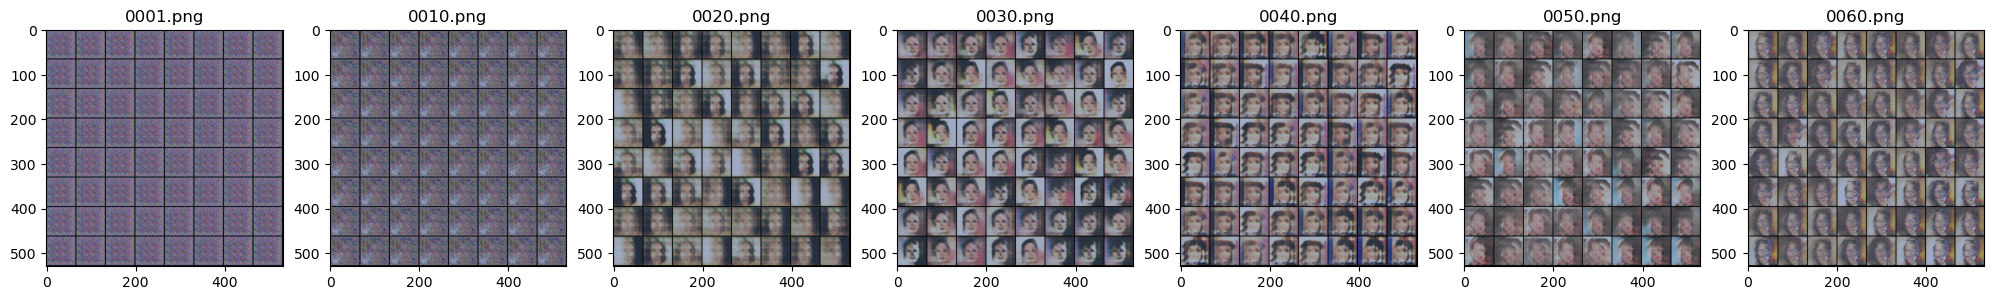

In [36]:
gen_image_id_list = ['0001', '0010', '0020', '0030', '0040', '0050', '0060']

relpath = os.path.join(
    'generated', 
    MODE,
    'xfer_{}'.format(TRANSFER_LEARNING),
    str(N_SAMPLES))
gen_image_path_list = [ os.path.join(os.getcwd(),
                                     relpath,
                                    'generated-images-{}.png'.format(id)) for id in gen_image_id_list]


fig, ax = plt.subplots(1, len(gen_image_id_list), figsize=(25,25))
for i, gen_image_path in enumerate(gen_image_path_list):
    img = plt.imread(gen_image_path)
    ax[i].imshow(img)
    ax[i].set(title = str(gen_image_id_list[i]) +'.png')


#### Load metrics from file

In [37]:
MODEL_DIR, METRICS_FILE

('c:\\Users\\Admin\\Desktop\\GAN_sharing_AIAP\\model\\gan\\xfer_True\\10000',
 'metrics-gan-samples-10000-xfer-learn-True.csv')

In [38]:
metrics_filepath = os.path.join(os.getcwd(), MODEL_DIR, METRICS_FILE)
#metrics_filepath = os.path.join(os.getcwd(), 'model', 'lsgan', '10000','metrics-lsgan-samples-10000.csv')
metrics_df = pd.read_csv(metrics_filepath, index_col = 'Cycle')

#### Loss and score visualisations



We can also visualize how the loss changes over time (training cycle: loss calculated for each batch of data (BATCH_SIZE)). Visualizing losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.

Total training cycles = Number of sample images / batch size per cycle * epochs

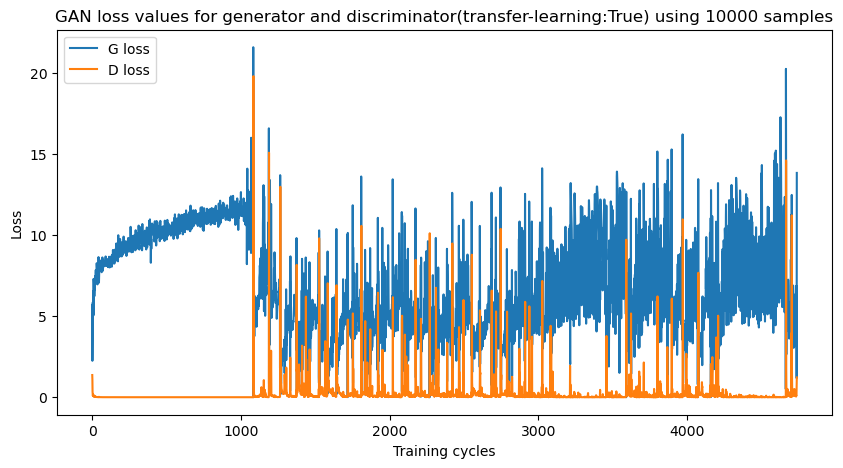

In [39]:
plt.figure(figsize=(10,5))
# Take 50 cycle moving averages to make the plots less noisy. 

plt.plot(metrics_df['G_loss'], label = 'G loss')
plt.plot(metrics_df['D_loss'], label = 'D loss')
plt.xlabel('Training cycles')
plt.ylabel('Loss')
plt.title('{} loss values for generator and discriminator(transfer-learning:{}) using {} samples'.format(MODE.upper(), TRANSFER_LEARNING, N_SAMPLES))
plt.legend()

# save plot
loss_plot_fname = 'loss-{}-sample-{}-xfer-{}.png'.format(MODE, N_SAMPLES, TRANSFER_LEARNING)
plt.savefig(loss_plot_fname)

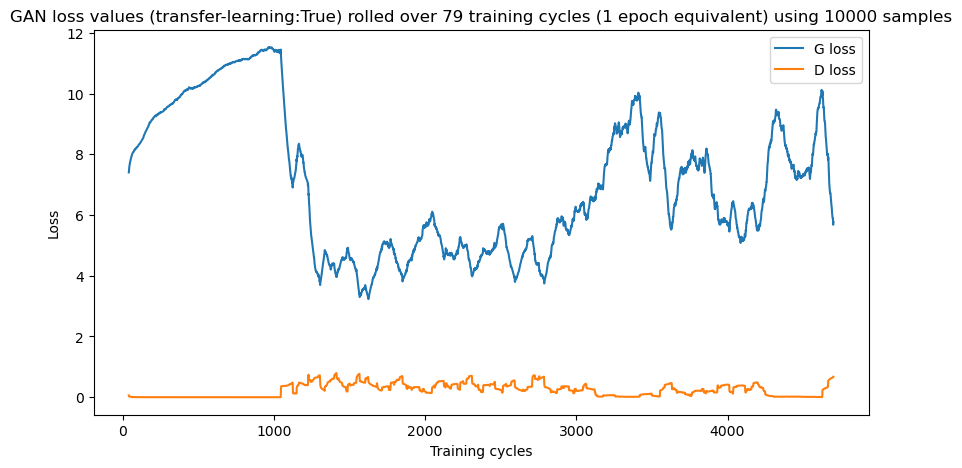

In [40]:
# Plot rolling mean for loss values
plt.figure(figsize=(10,5))
# Take 50 cycle moving averages to make the plots less noisy. 

plt.plot(metrics_df['G_loss'].rolling(math.ceil(N_SAMPLES/BATCH_SIZE), center=True).mean(), label = 'G loss')
plt.plot(metrics_df['D_loss'].rolling(math.ceil(N_SAMPLES/BATCH_SIZE), center=True).mean(), label = 'D loss')
plt.xlabel('Training cycles')
plt.ylabel('Loss')
plt.title('{} loss values (transfer-learning:{}) rolled over {} training cycles (1 epoch equivalent) using {} samples'.format(MODE.upper(), TRANSFER_LEARNING, math.ceil(N_SAMPLES/BATCH_SIZE) ,N_SAMPLES))
plt.legend()

# save plot
loss_plot_fname = 'loss-{}-rolled-sample-{}-xfer-{}.png'.format(MODE, N_SAMPLES, TRANSFER_LEARNING)
plt.savefig(loss_plot_fname)

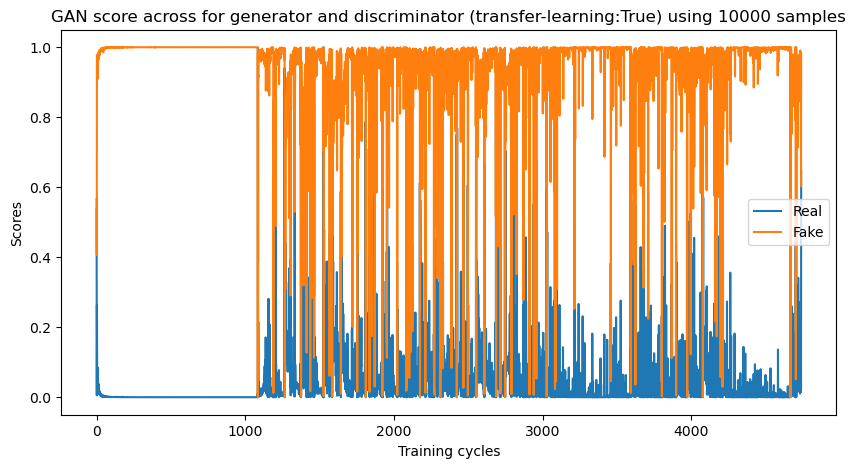

In [41]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df['Fake_score'], label = 'Fake score') 
plt.plot(metrics_df['Real_score'], label = 'Real score') 

plt.xlabel('Training cycles')
plt.ylabel('Scores')
plt.legend(['Real', 'Fake'], loc='best')
plt.title('{} score across for generator and discriminator (transfer-learning:{}) using {} samples'.format(MODE.upper(), TRANSFER_LEARNING, N_SAMPLES))
# save plot
score_plot_fname = 'score-{}-sample-{}-xfer-{}.png'.format(MODE, N_SAMPLES, TRANSFER_LEARNING)
plt.savefig(score_plot_fname)

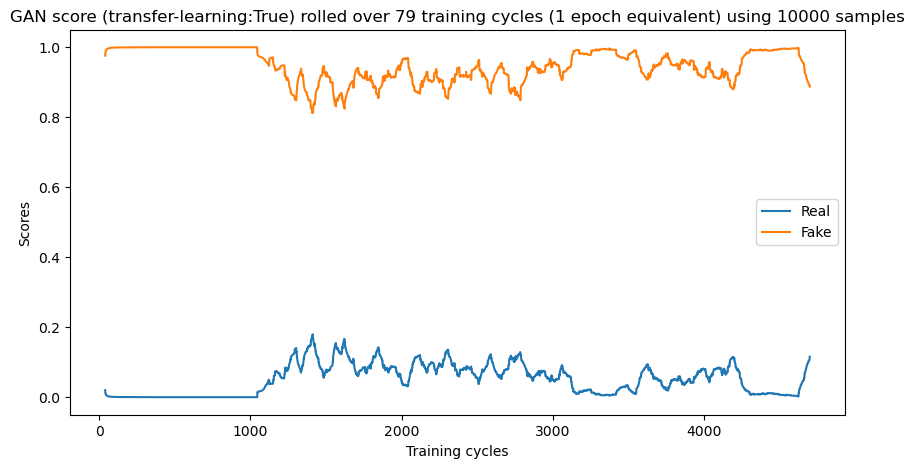

In [42]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df['Fake_score'].rolling(math.ceil(N_SAMPLES/BATCH_SIZE), center=True).mean(), label = 'Fake score') 
plt.plot(metrics_df['Real_score'].rolling(math.ceil(N_SAMPLES/BATCH_SIZE), center=True).mean(), label = 'Real score') 

plt.xlabel('Training cycles')
plt.ylabel('Scores')
plt.legend(['Real', 'Fake'], loc='best')
plt.title('{} score (transfer-learning:{}) rolled over {} training cycles (1 epoch equivalent) using {} samples'.format(MODE.upper(), TRANSFER_LEARNING, math.ceil(N_SAMPLES/BATCH_SIZE), N_SAMPLES))
# save plot
score_plot_fname = 'score-{}-rolled-sample-{}-xfer-{}.png'.format(MODE, N_SAMPLES, TRANSFER_LEARNING)
plt.savefig(score_plot_fname)

#### Make gif from images for different GAN directories

In [43]:
# Make gif

def make_gif(frame_folder, gif_name):
    """This function creates a gif file by using all png extension images
    from a given folder path which contains such files.

    Args:
      frame folder (string): 
          Path to image frames folder.
      gif_name (string):
          Gif filename to use for saving.

    Returns:
        None

    Raises:
        None
    """
    frames = [PIL.Image.open(image) for image in glob.glob(f"{frame_folder}/*.PNG")]
    frame_one = frames[0]
    frame_one.save(gif_name, format="GIF", append_images=frames,
               save_all=True, duration=5, loop=0)

    return None

In [44]:
mode_folder_path = os.path.join(os.getcwd(), SAMPLE_DIR_GENERATED_IMAGE)
print(mode_folder_path)
make_gif(mode_folder_path, '{}-{}-xfer-{}.gif'.format(MODE, N_SAMPLES, TRANSFER_LEARNING))

c:\Users\Admin\Desktop\GAN_sharing_AIAP\generated\gan\xfer_True\10000
